## Load Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import re
from nltk.stem import PorterStemmer
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder

import pickle

## Load data

In [3]:
df = pd.read_csv("dataset/train.txt", header=None)
df.head()

,0
0,i didnt feel humiliated;sadness
1,i can go from feeling so hopeless to so damned...
2,im grabbing a minute to post i feel greedy wro...
3,i am ever feeling nostalgic about the fireplac...
4,i am feeling grouchy;anger


In [4]:
df = pd.read_csv("dataset/train.txt", header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")
df.head()

,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
# add new column name "length"
df['length'] = [len(x) for x in df['Comment']]
df.head()

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20


In [6]:
df.shape

(16000, 3)

## Exploratory Data Analysis (EDA)

In [7]:
df.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [8]:
df.duplicated().sum()

1

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df['Emotion'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [11]:
df['Emotion'].value_counts()

Emotion
joy         5361
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

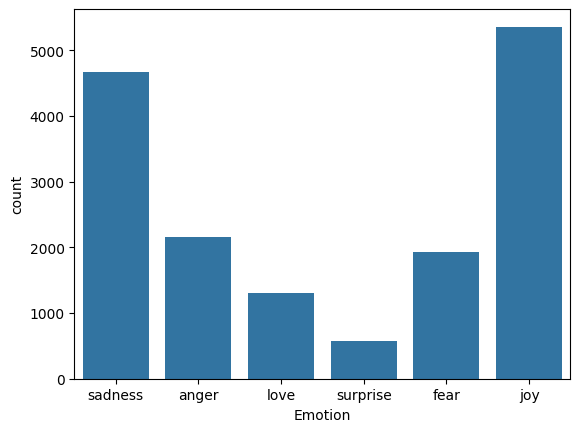

In [12]:
sns.countplot(x = df['Emotion'])
plt.show()

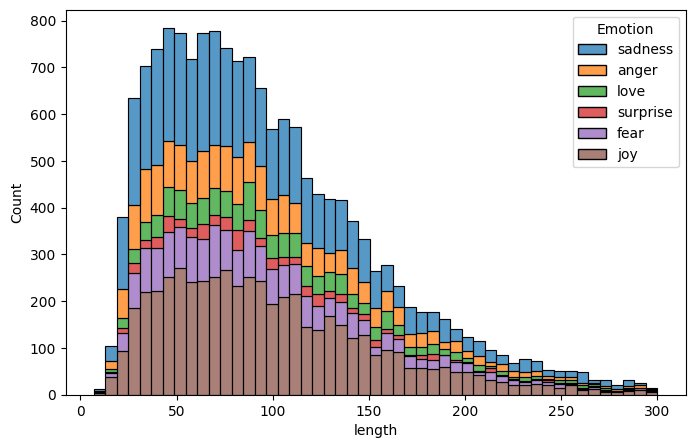

In [13]:
# data distribution
df1 = df.copy()
df1['length'] = [len(x) for x in df1['Comment']]

# Convert the 'length' column to a numpy array
length_values = df1['length'].values

# Use sns.histplot instead of sns.kdeplot for simplicity
plt.figure(figsize=(8, 5))
sns.histplot(data = df1, x = 'length', hue = 'Emotion', multiple = 'stack')
plt.show()

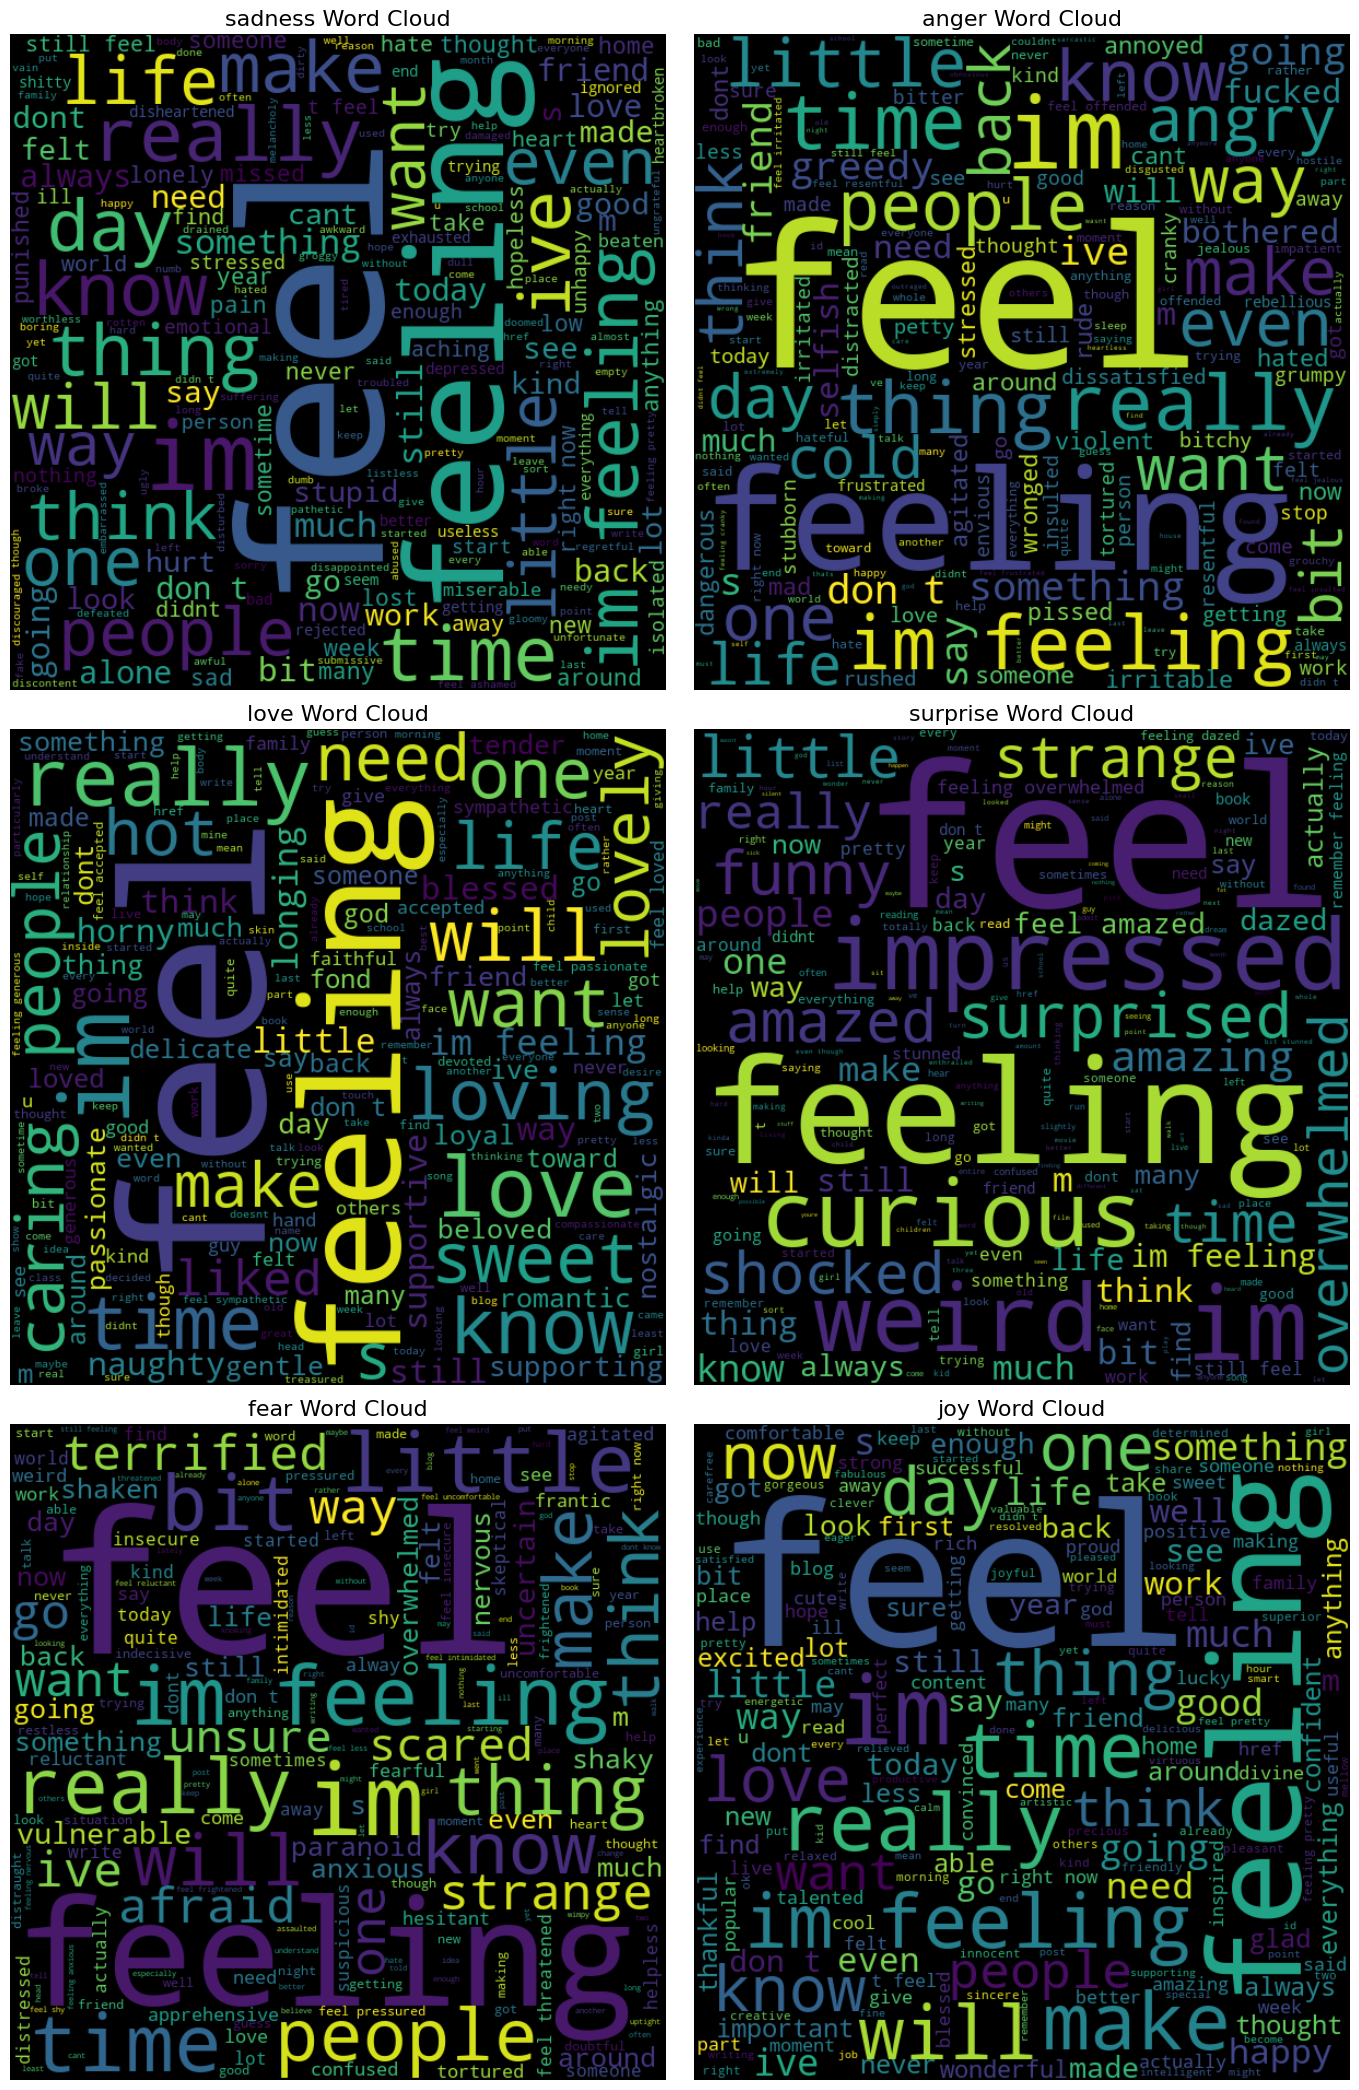

In [14]:
# Function to generate and display word clouds in 2 columns
def generate_wordclouds(data, column, text_column):
    emotions = data[column].unique()
    n_emotions = len(emotions)
    
    # Calculate number of rows for 2 columns
    n_rows = (n_emotions + 1) // 2
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, 2, figsize=(14, 7 * n_rows))
    axes = axes.flatten()  # Flatten axes for easy iteration
    
    for idx, emotion in enumerate(emotions):
        text = ' '.join(data.loc[data[column] == emotion, text_column])
        wordcloud = WordCloud(width=600, height=600).generate(text)
        
        # Display word cloud
        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].set_title(f'{emotion} Word Cloud', size=16)
        axes[idx].axis('off')
    
    # Turn off any unused axes
    for i in range(idx + 1, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

generate_wordclouds(df, column='Emotion', text_column='Comment')

## Data Preprocessing

In [15]:
le = LabelEncoder()
df['Emotion'] = le.fit_transform(df['Emotion'])

In [16]:
df['Emotion'].unique()

array([4, 0, 3, 5, 1, 2])

In [17]:
df.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


## Applying Machine Learning Algorithms

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [19]:
ml_df = df.copy()

In [20]:
ml_df.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [21]:
# Download NLTK stopwords
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

ml_df['cleaned_comment'] = ml_df['Comment'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hamza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
ml_df.head()

,Comment,Emotion,length,cleaned_comment
0,i didnt feel humiliated,4,23,didnt feel humili
1,i can go from feeling so hopeless to so damned...,4,108,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,0,48,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,3,92,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,0,20,feel grouchi


In [36]:
X = ml_df['cleaned_comment']  # Use the cleaned text data for vectorization
y = ml_df['Emotion']  # Target variable

In [37]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)  # Transform the text data into TF-IDF features

In [40]:
#print(X_tfidf)

In [41]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [44]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12799, 10359), (3200, 10359), (12799,), (3200,))

In [45]:
print(f"Shape of X_train_tfidf: {X_train.shape}")
print(f"Shape of y_train: {len(y_train)}")
print(f"Shape of X_test_tfidf: {X_test.shape}")
print(f"Shape of y_test: {len(y_test)}")

Shape of X_train_tfidf: (12799, 10359)
Shape of y_train: 12799
Shape of X_test_tfidf: (3200, 10359)
Shape of y_test: 3200


In [88]:
# Define classifiers
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Display results
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))



===== Multinomial Naive Bayes =====
Accuracy: 0.6553
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.31      0.47       439
           1       0.88      0.22      0.35       375
           2       0.58      0.97      0.72      1027
           3       1.00      0.03      0.05       303
           4       0.72      0.91      0.80       950
           5       0.00      0.00      0.00       106

    accuracy                           0.66      3200
   macro avg       0.69      0.41      0.40      3200
weighted avg       0.72      0.66      0.58      3200


===== Logistic Regression =====


C:\Users\Hamza\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hamza\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hamza\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8200
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       439
           1       0.85      0.71      0.77       375
           2       0.75      0.94      0.84      1027
           3       0.84      0.44      0.58       303
           4       0.87      0.92      0.90       950
           5       0.73      0.43      0.54       106

    accuracy                           0.82      3200
   macro avg       0.82      0.70      0.74      3200
weighted avg       0.83      0.82      0.81      3200


===== Random Forest =====
Accuracy: 0.8488
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       439
           1       0.84      0.83      0.84       375
           2       0.83      0.91      0.87      1027
           3       0.81      0.58      0.68       303
           4       0.92      0.88      0.90       950
           5       0.71  

In [89]:
# selecting model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_y_pred = rfc.predict(X_test)

## Testing ML Model

In [92]:
def predict_emotion(input_text):
    # Clean the input text
    cleaned_text = clean_text(input_text)
    input_vectorized = tfidf_vectorizer.transform([cleaned_text])

    # Predict emotion
    predicted_label = rfc.predict(input_vectorized)[0]
    
    # Map label to emotion name
    # emotion_mapping = {4: 'sadness', 0: 'anger', 3: 'love', 5: 'surprise', 1: 'fear', 2: 'joy'}
    # predicted_emotion = emotion_mapping[predicted_label]

    # return predicted_emotion, predicted_label

    predicted_emotion = le.inverse_transform([predicted_label])[0]
    label =  np.max(rfc.predict(input_vectorized))

    return predicted_emotion, label


# Example usage
sentences = [
    "i didnt feel humiliated",
    "i feel strong and good overall",
    "im grabbing a minute to post i feel greedy wrong",
    "He was speechless when he found out he was accepted to this new job",
    "This is outrageous, how can you talk like that?",
    "I feel like I'm all alone in this world",
    "He is really sweet and caring",
    "You made me very crazy",
    "I am ever feeling nostalgic about the fireplace I will know that it is still on the property",
    "I am feeling grouchy",
    "He hates you"
]

# Print predictions
for sentence in sentences:
    print(sentence)
    pred_emotion, label = predict_emotion(sentence)
    print("Prediction :", pred_emotion)
    print("Label :", label)
    print("=" * 64)


i didnt feel humiliated
Prediction : sadness
Label : 4
i feel strong and good overall
Prediction : joy
Label : 2
im grabbing a minute to post i feel greedy wrong
Prediction : anger
Label : 0
He was speechless when he found out he was accepted to this new job
Prediction : joy
Label : 2
This is outrageous, how can you talk like that?
Prediction : anger
Label : 0
I feel like I'm all alone in this world
Prediction : sadness
Label : 4
He is really sweet and caring
Prediction : love
Label : 3
You made me very crazy
Prediction : anger
Label : 0
I am ever feeling nostalgic about the fireplace I will know that it is still on the property
Prediction : love
Label : 3
I am feeling grouchy
Prediction : anger
Label : 0
He hates you
Prediction : anger
Label : 0


## Save ML models

In [90]:
# Save ML model
with open('models/rfc_model.pkl', 'wb') as f:
    pickle.dump(rfc, f)
    
# Save the TF-IDF vectorizer
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

## Applying Deep learning Using LSTM

In [33]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
#from keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [34]:
dl_df = df.copy()

In [35]:
dl_df.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [36]:
# Text cleaning function
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)

    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad

# Text cleaning and encoding
x_train = text_cleaning(dl_df, "Comment", vocab_size=11000, max_len=300)
y_train = to_categorical(dl_df["Emotion"])

## Model Building and Training

In [50]:
# Build the model
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

# Build the model explicitly
model.build(input_shape=(None, 300))  # Batch size is unspecified (None)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 300, 150)            │       1,650,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 300, 150)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 128)                 │         142,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,801,494 (6.87 MB)

 Trainable params: 1,801,494 (6.87 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Train the model
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

In [52]:
model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 111s 436ms/step - accuracy: 0.3088 - loss: 1.6467
Epoch 2/10


C:\Users\Hamza\miniconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 107s 426ms/step - accuracy: 0.6294 - loss: 1.0445
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 107s 427ms/step - accuracy: 0.8523 - loss: 0.4598
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 135s 541ms/step - accuracy: 0.9033 - loss: 0.2900
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 114s 455ms/step - accuracy: 0.9353 - loss: 0.1981
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 125s 501ms/step - accuracy: 0.9502 - loss: 0.1534
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 119s 475ms/step - accuracy: 0.9585 - loss: 0.1279
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 120s 479ms/step - accuracy: 0.9604 - loss: 0.1136
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 123s 491ms/step - accuracy: 0.9678 - loss: 0.0949
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 131s 523ms/step - accuracy: 0.9690 - loss: 0.0857


## Testing DL Model

In [54]:
# Text cleaning function
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding='pre')
    return pad

# load model and predict 
sentences = [
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

i feel strong and good overall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
joy : 0.9988307356834412


im grabbing a minute to post i feel greedy wrong
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
anger : 0.9976673722267151


He was speechles when he found out he was accepted to this new job
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
joy : 0.4836796522140503


This is outrageous, how can you talk like that?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
anger : 0.8853968977928162


I feel like im all alone in this world
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
sadness : 0.9976031184196472


He is really sweet and caring
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
love : 0.9783828854560852


You made me very crazy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
sadness 

## Save model And Other Files

In [55]:
model.save('models/dl_model.h5')

# Save the LabelEncoder
with open('models/label.pkl', 'wb') as f:
    pickle.dump(le, f)

# Save vocabulary size and max length
vocab_info = {'vocab_size': 11000, 'max_len': 300}
with open('models/vocab_info.pkl', 'wb') as f:
    pickle.dump(vocab_info, f)